## Weighted Vector Search

**THIS IS NOT THE FINAL MODEL**

This notebook is included for integrity as it shows the implementation of the optimal weight vector search. Conceptually the cells to be considered are in the last section. The others are related to the ensemble method as described in the report.

### Connect to Drive

In [15]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
%cd /gdrive/My Drive/Colab Notebooks/Homework2

/gdrive/My Drive/Colab Notebooks/Homework2


### Import libraries

In [17]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from random import shuffle
import pickle
import warnings
import logging


plt.rc('font', size=16) 
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [18]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)

In [19]:
x_dataset = np.load('x_train.npy')
y_dataset = np.load('y_train.npy')

In [20]:
scaler = RobustScaler()
X_train_scaler = scaler.fit_transform(x_dataset.reshape(-1, x_dataset.shape[-1]))
x_dataset = X_train_scaler.reshape(x_dataset.shape)

file = open('scaler', 'wb')
pickle.dump(scaler, file)
file.close()


x_train_da, x_test_val, y_train_da, y_test_val = train_test_split(x_dataset, y_dataset, test_size=0.2, stratify=y_dataset)
# print(x_train_da.shape)
# print(y_train_da.shape)
# print('y_dataset:', Counter(y_dataset))
# print('y_train_da:', Counter(y_train_da))

#In order to exploit the whole dataset, the submitted models have been trained
#without a test set, the following two lines are kept for integrity.
# x_val_da = x_test_val
# y_val_da = y_test_val

x_test_da, x_val_da, y_test_da, y_val_da = train_test_split(x_test_val, y_test_val, test_size=0.5, stratify=y_test_val) #se aumento test_size aumento la percentuale di validation
# print(x_test_da.shape)
# print(y_test_da.shape)
# print(x_val_da.shape)
# print(y_val_da.shape)
# print('y_test_da:', Counter(y_test_da))
# print('y_val_da:', Counter(y_val_da))

In [21]:
def oversampling(x_train, y_dataset):

  # print(x_train.shape)
  shape_x = x_train.shape[0]
  
  warnings.filterwarnings(action='ignore', category=DeprecationWarning)
  
  #The following ratio is aimed at mitigating the effect of the gap in different
  #amounts of samples between classes. However, to avoid overfitting, smallest 
  #classes have been oversampledof a factor not greater than 3.0
  ratio = {
            0 : ( (int) (Counter(y_train_da)[0] * 3.0)),
            1 : ( (int) (Counter(y_train_da)[1] * 1.2)),
            2 : ( (int) (Counter(y_train_da)[2] * 1.15)),
            3 : ( (int) (Counter(y_train_da)[3] * 1.25)),
            4 : ( (int) (Counter(y_train_da)[4] * 2.0)),
            5 : ( (int) (Counter(y_train_da)[5] * 1.2)),
            6 : ( (int) (Counter(y_train_da)[6] * 1.0)),
            7 : ( (int) (Counter(y_train_da)[7] * 1.75)),
            8 : ( (int) (Counter(y_train_da)[8] * 1.2)),
            9 : ( (int) (Counter(y_train_da)[9] * 1.0)),
            10 : ( (int) (Counter(y_train_da)[10] * 1.7)),
            11 : ( (int) (Counter(y_train_da)[11] * 2.0))  
           }
  count = 0
  for i in ratio.values():
    count += i
  #sampling_strategy=ratio
  sm = SMOTE(sampling_strategy=ratio)

  X_train_scaled_resahaped = x_train.reshape((-1, x_train.shape[0]))
  X_train_scaled_resahaped = X_train_scaled_resahaped.reshape((shape_x, 216))


  ### Resample X_train_scaled
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled_resahaped, y_dataset)
  # print(X_train_resampled.shape)
  # print(y_train_resampled.shape)
  #x_dataset = X_train_resampled.reshape((count, 36, 6))
  x_dataset = X_train_resampled.reshape((X_train_resampled.shape[0], 36, 6))
  # print(x_dataset.shape)

  # print('Original dataset shape:', Counter(y_dataset))
  # print('Resampled dataset shape:', Counter(y_train_resampled))
  # print(y_train_resampled.shape)

  return x_dataset, y_train_resampled

In [22]:
x_train, y_train_dacat = oversampling(x_train_da, y_train_da)

y_train = tfk.utils.to_categorical(y_train_dacat)
y_val = tfk.utils.to_categorical(y_val_da)
y_test = tfk.utils.to_categorical(y_test_da)

#Additional reshuffle of every split

ind_list = [i for i in range(x_train.shape[0])]
shuffle(ind_list)
x_train = x_train[ind_list]
y_train = y_train[ind_list]

ind_list = [i for i in range(x_val_da.shape[0])]
shuffle(ind_list)
x_val_da = x_val_da[ind_list]
y_val = y_val[ind_list]

ind_list = [i for i in range(x_test_da.shape[0])]
shuffle(ind_list)
x_test_da = x_test_da[ind_list]
y_test = y_test[ind_list]

In [23]:
def add_noise(signal):
    noise = np.random.normal(0, 1, signal.shape)
    return signal + noise
def scale(signal):
    scaling_factor = np.random.uniform(0.5, 1.5)
    return signal * scaling_factor
# Time shifting: Shift the signal along the time axis by a random number of samples.
def time_shift(signal):
    shift = np.random.randint(-5, 5)
    return np.roll(signal, shift, axis=0)
# Vertical shifting: Shift the signal along the vertical axis by a random amount.
def vertical_shift(signal):
    shift = np.random.uniform(-1, 1)
    return signal + shift
# Random cropping: Select a random portion of the signal and return it. 
#This can be done by using the np.random.randint function to generate random indices for the start and end of the crop,
# and then using these indices to slice the signal.
def random_crop(signal):
    start = np.random.randint(0, signal.shape[0] - 10)
    end = start + np.random.randint(10, signal.shape[0] - start)
    return signal[start:end]

In [24]:
def aug_time_series(time_series):
  add_noise(time_series)
  scale(time_series)
  time_shift(time_series)
  vertical_shift(time_series)
  random_crop(time_series)

#Data Augmentation is applied on the training set only
aug_time_series(x_train)

### Build and train models

In [25]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
units = 512

# Map activities to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11
}

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs
)

In [26]:
#In the best model this architecture actually is not included, this is kept for integrity

def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(units, return_sequences=True)(input_layer)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)

    lstm = tfkl.LSTM(units,return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)

    lstm = tfkl.LSTM(units, return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)
    
    lstm = tfkl.LSTM(units)(lstm)
    
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)

    output_layer = tfkl.Dense(classes, activation='softmax')(lstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

def build_RNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #noise = tf.keras.layers.GaussianNoise(0.05)(input_layer)

    # Feature extractor
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    rnn = tfkl.GRU(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.GRU(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    #The insertion of a final SimpleRNN layer attcached to the GRU layers is on 
    # purpose as it suffered less overfitting
    rnn = tfkl.SimpleRNN(units, return_sequences=False)(rnn)
    rnn = tfkl.Dropout(0.6, seed=seed)(rnn)

    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)

    output_layer = tfkl.Dense(classes, activation='softmax')(rnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model



def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(input_layer)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(bilstm)
    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units))(bilstm)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    # Classifier
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    output_layer = tfkl.Dense(classes, activation='softmax')(bilstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model




def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    # Classifier
    
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model


def build_CNN_BILSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)
    # Classifier
    
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)


    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [27]:
# model.save('LSTM_6904')

In [28]:
# train models and keep them in memory

models = list()

# model = build_LSTM_classifier(input_shape, classes)
# models.append(model)

model = build_RNN_classifier(input_shape, classes)
models.append(model)

model = build_BiLSTM_classifier(input_shape, classes)
models.append(model)

model = build_1DCNN_classifier(input_shape, classes)
models.append(model)

model = build_CNN_BILSTM_classifier(input_shape, classes)
models.append(model)

epochs = 150

for i in range(len(models)):
  models[i].fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_data = (x_val_da,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
        ]
    )

Epoch 1/150
19/19 [==============================] - 5s 90ms/step - loss: 2.1036 - accuracy: 0.2986 - val_loss: 1.8687 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 2/150
19/19 [==============================] - 1s 47ms/step - loss: 1.9253 - accuracy: 0.3520 - val_loss: 1.8474 - val_accuracy: 0.2428 - lr: 0.0010
Epoch 3/150
19/19 [==============================] - 1s 48ms/step - loss: 1.8437 - accuracy: 0.3499 - val_loss: 1.6329 - val_accuracy: 0.4362 - lr: 0.0010
Epoch 4/150
19/19 [==============================] - 1s 47ms/step - loss: 1.7052 - accuracy: 0.4011 - val_loss: 1.4705 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 5/150
19/19 [==============================] - 1s 47ms/step - loss: 1.6529 - accuracy: 0.4259 - val_loss: 1.4538 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 6/150
19/19 [==============================] - 1s 46ms/step - loss: 1.5681 - accuracy: 0.4515 - val_loss: 1.5099 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 7/150
19/19 [==============================] - 1s 47ms/step - lo

8/8 [==============================] - 1s 6ms/step
0 :
Accuracy: 0.6173
Precision: 0.5298
Recall: 0.472
F1: 0.4867
1 :
Accuracy: 0.7037
Precision: 0.7083
Recall: 0.6233
F1: 0.6409
2 :
Accuracy: 0.7202
Precision: 0.7381
Recall: 0.5966
F1: 0.6262
3 :
Accuracy: 0.7119
Precision: 0.6542
Recall: 0.6336
F1: 0.6384


ENSEMBLE:
Accuracy: 0.749
Precision: 0.7209
Recall: 0.6075
F1: 0.6334


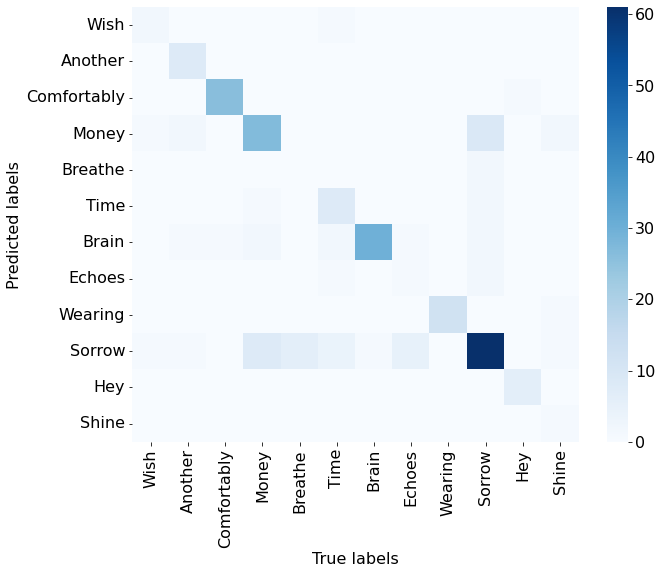

In [29]:
#Predictions on the local dataset of single models
yhats = [model.predict(x_test_da) for model in models]
yhats = np.array(yhats)

for i in range(len(yhats)):
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  print(i,':')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))



#Predictions on the local dataset of the Ensemble method
predictions = np.mean(yhats, axis=0)

accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('\n\nENSEMBLE:')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

#Confusion matrix of the ensemble method
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [30]:
#To submit the best model for each architecture we saved at each time by hand only in case of good performances
# models[0].save('model0')
# models[1].save('model0')
# models[2].save('model0')
# models[3].save('model0')
# models[4].save('model0')

## Optimal Weight Vector Search

In [31]:
# yhats = [model.predict(x_test_da) for model in models]
# yhats = np.array(yhats)
# for i in range(yhats.shape[1]):
#   for j in range(yhats.shape[0]):
#     yhats[j,i,:] = yhats[j,i,:]*weights[j]
# predictions = np.sum(yhats, axis=0)

# copyYhats = np.ndarray.copy(yhats)
# weights = [,,,,]

maxAccuracy = 0.0
bestWeights = list()

#In the following nested loops the counter is in range (20) to search combination based on
#multiples of 5. A complete search (range(100)) was computationally prohibitive.


for w1 in range(20):
  for w2 in range(20):
    for w3 in range(20):
      for w4 in range(20):
        for w5 in range(20):
          if ( w1+w2+w3+w4+w5 == 20.0):
            
            weights = [ (w1/20.0), (w2/20.0), (w3/20.0), (w4/20.0), (w5/20.0) ]
            copyYhats = np.ndarray.copy(yhats)
            # print('I:',copyYhats)
            for i in range(copyYhats.shape[1]):
              for j in range(copyYhats.shape[0]):
                copyYhats[j,i,:] = yhats[j,i,:]*weights[j]
            # print('F:',copyYhats)
            predictions = np.sum(copyYhats, axis=0)

            temp = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

            print('__________________\n', np.array(weights),' --> ', temp)

            if temp == maxAccuracy:
              bestWeights.append(weights)

            if temp > maxAccuracy:
              maxAccuracy = temp
              bestWeights.clear() 
              bestWeights.append(weights)


print('BEST SCORES: \n Accuracy = ', maxAccuracy, '\nWeights = ', bestWeights)

Output streaming troncato alle ultime 5000 righe.
 [0.3  0.35 0.   0.   0.35]  -->  0.7119341563786008
__________________
 [0.3  0.35 0.   0.05 0.3 ]  -->  0.7119341563786008
__________________
 [0.3  0.35 0.   0.1  0.25]  -->  0.7160493827160493
__________________
 [0.3  0.35 0.   0.15 0.2 ]  -->  0.7160493827160493
__________________
 [0.3  0.35 0.   0.2  0.15]  -->  0.720164609053498
__________________
 [0.3  0.35 0.   0.25 0.1 ]  -->  0.720164609053498
__________________
 [0.3  0.35 0.   0.3  0.05]  -->  0.7283950617283951
__________________
 [0.3  0.35 0.   0.35 0.  ]  -->  0.7366255144032922
__________________
 [0.3  0.35 0.05 0.   0.3 ]  -->  0.6954732510288066
__________________
 [0.3  0.35 0.05 0.05 0.25]  -->  0.7119341563786008
__________________
 [0.3  0.35 0.05 0.1  0.2 ]  -->  0.7078189300411523
__________________
 [0.3  0.35 0.05 0.15 0.15]  -->  0.7160493827160493
__________________
 [0.3  0.35 0.05 0.2  0.1 ]  -->  0.7407407407407407
__________________
 [0.3  0.35 0.05

In the following cell some valid results obtained with the previous cell have been annoted.

In [32]:
# print('BEST SCORES: \nAccuracy = ', maxAccuracy, '\nWeights = ', bestWeights)

# Sub1: [0.05, 0.35, 0.1, 0.45, 0.05]

# Sub2: [0.05, 0.4, 0.0, 0.05, 0.5]


# BEST SCORES: 
# Accuracy =  0.7371134020618557 
# Weights =  [0.0, 0.0, 0.04, 0.37, 0.59]

# BEST SCORES: 
# Accuracy =  0.7525773195876289 
# Weights =  [[0.0, 0.35, 0.15, 0.5, 0.0], [0.05, 0.35, 0.1, 0.45, 0.05], [0.05, 0.35, 0.15, 0.45, 0.0]]  ==> Submitted

#Aumentando la patience (25,10)
# BEST SCORES: 
# Accuracy =  0.7680412371134021 
# Weights =  [[0.0, 0.2, 0.2, 0.2, 0.4]]     ==> Submitted

# BEST SCORES: patience (20,10), Split(85 - 75)
# Accuracy =  0.7802197802197802 
# Weights =  [[0.0, 0.45, 0.0, 0.1, 0.45], [0.05, 0.4, 0.0, 0.05, 0.5]]

# BEST SCORES: patience (20,10), Split(85 - 65)
#  Accuracy =  0.7637795275590551 
# Weights =  [[0.15, 0.0, 0.45, 0.3, 0.1], [0.2, 0.0, 0.4, 0.3, 0.1], [0.3, 0.0, 0.25, 0.35, 0.1], [0.35, 0.0, 0.25, 0.3, 0.1]]



ENSEMBLE:
Accuracy: 0.749
Precision: 0.7209
Recall: 0.6075
F1: 0.6334


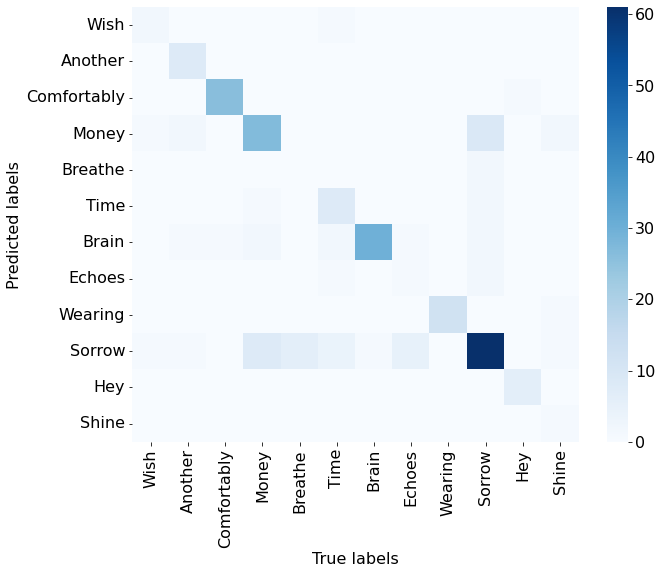

In [33]:
#Here a cell for the comparison of the weighted sum results and the plain mean prediction

predictions = np.mean(yhats, axis=0)

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
#accuracy = accuracy_score(np.argmax(y_test, axis=-1), predictions)
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('\n\nENSEMBLE:')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


# Compute and plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()